In [ ]:
# Cài đặt API của Kaggle
import os

os.environ['KAGGLE_USERNAME'] = "KAGGLE_USERNAME"
os.environ['KAGGLE_KEY'] = "KAGGLE_KEY"

# Tải dữ liệu từ Kaggle
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

# Giải nén dữ liệu
from zipfile import ZipFile

file_name = '/content/microsoft-catsvsdogs-dataset.zip'

with ZipFile(file_name, 'r') as z:
    z.extractall()
    print("Giải nén dữ liệu hoàn tất.")

Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset
License(s): other
microsoft-catsvsdogs-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Giải nén dữ liệu hoàn tất.


In [2]:
# Import các thư viện cần thiết
import os
import random
from shutil import copyfile
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Định nghĩa các thư mục
CAT_DIR = '/content/PetImages/Cat'
DOG_DIR = '/content/PetImages/Dog'
BASE_DIR = '/tmp/cats-v-dogs'
TRAINING_DIR = os.path.join(BASE_DIR, 'training')
VALIDATION_DIR = os.path.join(BASE_DIR, 'validation')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Tạo thư mục
dirs = [
    TRAINING_DIR, VALIDATION_DIR, TEST_DIR,
    os.path.join(TRAINING_DIR, 'cats'), os.path.join(TRAINING_DIR, 'dogs'),
    os.path.join(VALIDATION_DIR, 'cats'), os.path.join(VALIDATION_DIR, 'dogs'),
    os.path.join(TEST_DIR, 'cats'), os.path.join(TEST_DIR, 'dogs')
]
for directory in dirs:
    os.makedirs(directory, exist_ok=True)

# Hàm kiểm tra ảnh hợp lệ
def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Kiểm tra file ảnh
        return True
    except (IOError, SyntaxError):
        return False

# Hàm chia dữ liệu với kiểm tra file ảnh
def split_data(main_dir, training_dir, validation_dir, test_dir=None, include_test=True, split_size=0.8):
    files = [f for f in os.listdir(main_dir) if os.path.getsize(os.path.join(main_dir, f)) > 0]
    valid_files = [f for f in files if is_valid_image(os.path.join(main_dir, f))]  # Chỉ giữ ảnh hợp lệ
    random.shuffle(valid_files)

    train_split = int(split_size * len(valid_files))
    validation_split = int(train_split + (len(valid_files) - train_split) / 2)

    train_files = valid_files[:train_split]
    validation_files = valid_files[train_split:validation_split]
    test_files = valid_files[validation_split:] if include_test else []

    for file in train_files:
        copyfile(os.path.join(main_dir, file), os.path.join(training_dir, file))
    for file in validation_files:
        copyfile(os.path.join(main_dir, file), os.path.join(validation_dir, file))
    if include_test:
        for file in test_files:
            copyfile(os.path.join(main_dir, file), os.path.join(test_dir, file))

# Chia dữ liệu cho mèo và chó
split_data(CAT_DIR, os.path.join(TRAINING_DIR, 'cats'), os.path.join(VALIDATION_DIR, 'cats'), os.path.join(TEST_DIR, 'cats'))
split_data(DOG_DIR, os.path.join(TRAINING_DIR, 'dogs'), os.path.join(VALIDATION_DIR, 'dogs'), os.path.join(TEST_DIR, 'dogs'))

print("Dữ liệu đã được chia xong.")

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Dữ liệu đã được chia xong.


In [3]:
# Tăng cường dữ liệu bằng ImageDataGenerator
train_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

validation_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

# Tạo generator
train_generator = train_gen.flow_from_directory(
    TRAINING_DIR, target_size=(224, 224), batch_size=64, class_mode='binary', shuffle=True
)

validation_generator = validation_gen.flow_from_directory(
    VALIDATION_DIR, target_size=(224, 224), batch_size=64, class_mode='binary'
)

test_generator = test_gen.flow_from_directory(
    TEST_DIR, target_size=(224, 224), batch_size=64, class_mode='binary'
)

Found 24996 images belonging to 2 classes.
Found 11732 images belonging to 2 classes.
Found 11771 images belonging to 2 classes.


In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# Load mô hình VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

# Thêm các lớp tùy chỉnh
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Định nghĩa các callbacks
checkpoint = ModelCheckpoint(
    './Dogs_Cats.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1)

reduce_lr = ReduceLROnPlateau(
    factor=0.1,
    patience=1,
    verbose=1
)

# Huấn luyện mô hình
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[checkpoint, reduce_lr],
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  7/391 ━━━━━━━━━━━━━━━━━━━━ 5:48 909ms/step - accuracy: 0.7258 - loss: 0.6139

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - accuracy: 0.9471 - loss: 0.1445
Epoch 1: val_loss improved from inf to 0.04471, saving model to ./Dogs_Cats.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 479s 1s/step - accuracy: 0.9471 - loss: 0.1444 - val_accuracy: 0.9841 - val_loss: 0.0447 - learning_rate: 0.0010
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.9741 - loss: 0.0724
Epoch 2: val_loss improved from 0.04471 to 0.03796, saving model to ./Dogs_Cats.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 397s 1000ms/step - accuracy: 0.9741 - loss: 0.0724 - val_accuracy: 0.9865 - val_loss: 0.0380 - learning_rate: 0.0010
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.9770 - loss: 0.0623
Epoch 3: val_loss improved from 0.03796 to 0.03222, saving model to ./Dogs_Cats.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 438s 995ms/step - accuracy: 0.9770 - loss: 0.0623 - val_accuracy: 0.9891 - val_loss: 0.0322 - learning_rate: 0.0010
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accu

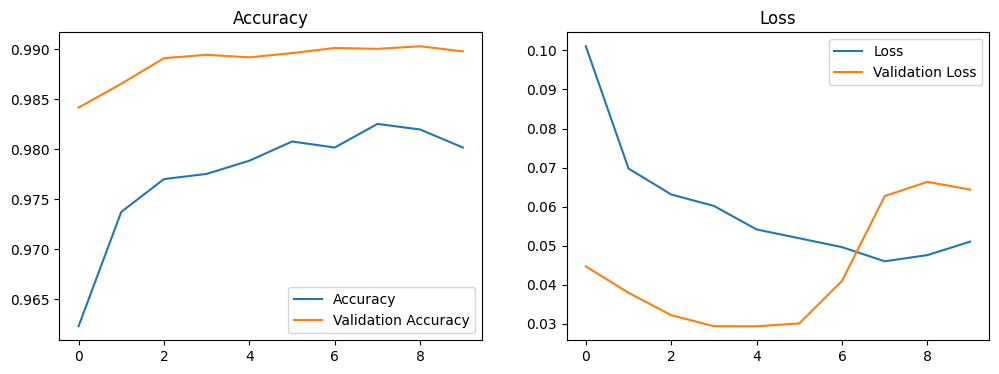

In [5]:
# Trực quan hóa kết quả
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [6]:
model.evaluate(test_generator, batch_size=64)

184/184 ━━━━━━━━━━━━━━━━━━━━ 73s 395ms/step - accuracy: 0.9896 - loss: 0.0286


[0.02503027580678463, 0.9906550049781799]

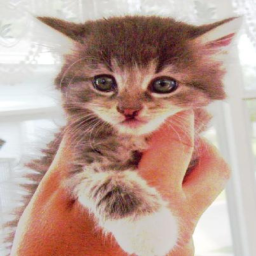

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction: Cat



In [10]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2
from google.colab.patches import cv2_imshow #Với Colab
def predict_image(model, img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = img_array.reshape((1, 224, 224, 3))
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)

    prediction = model.predict(img_array)[0][0]
    label = "Dog" if prediction > 0.5 else "Cat"
    return label

example_dir = '/content/PetImages/Cat/100.jpg'
image = cv2.imread(example_dir, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_AREA) #Hiển thị theo kích thước 256x256
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()
print("Prediction:", predict_image(model, example_dir))
print()

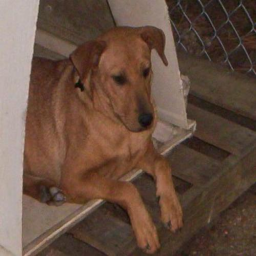

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction: Dog



In [9]:
example_dir = '/content/PetImages/Dog/100.jpg'
image = cv2.imread(example_dir, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_AREA)
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()
print("Prediction:", predict_image(model, example_dir))
print()